# Define Chesapeake Zones

This notebook creates a netcdf file that defines the boundaries of the upper, middle, and lower Bay in the coordinate axes of the Geo-Polar SST dataset.

Followed https://corteva.github.io/geocube/html/examples/zonal_statistics.html 

### INTERNET
1. install geocube in the `chesapeake_mhw` environment
- `conda install -n chesapeake_mhw geocube -y`
2. Is `chesapeake_stats_zones.geojson` saved somewhere? Maybe google drive? Path perhaps at /Users/rwegener/repos/mhw_ocetrac_census/data/chesapeake_stats_zones.geojson

In [1]:
import os
from pathlib import Path

import xarray as xr
import geopandas as gpd
from geocube.api.core import make_geocube

In [2]:
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')
REPO_ROOT = Path(REPO_ROOT)

In [3]:
path = (
    REPO_ROOT / 'data/raw' /
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [13]:
geopolar.rio.write_crs('epsg:4326', inplace=True)

<xarray.DataArray 'analysed_sst' (time: 7710, lat: 65, lon: 40)>
[20046000 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 2002-09-01T12:00:00 ... 2023-10-17T12:...
  * lat          (lat) float32 36.78 36.83 36.88 36.92 ... 39.88 39.92 39.97
  * lon          (lon) float32 -77.47 -77.43 -77.38 ... -75.62 -75.57 -75.53
    spatial_ref  int64 0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -200
    valid_max:      4000
    reference:      Fieguth,P.W. et al. "Mapping Mediterranean altimeter data...
    source:         STAR-ACSPO_GAC, STAR-ACSPO_H-8, STAR-Geo_SST, UKMO-OSTIA
    comment:        Analysed SST for each ocean grid point

TODO: find this geojson file

In [8]:
zones = gpd.read_file(
    REPO_ROOT / 'data' / 'chesapeake_traditional_zones.geojson'
)
zones = zones.explode(index_parts=True).droplevel(1)

Create a raster from the geojson shape

In [9]:
zones

,id,name,geometry
0,0,upper,"POLYGON ((-75.92652 38.84146, -76.07321 38.804..."
1,2,lower,"POLYGON ((-75.97078 37.18116, -76.00552 36.896..."
2,1,middle,"POLYGON ((-75.92652 38.84146, -75.80979 38.756..."


In [14]:
geocube = make_geocube(
    vector_data=zones,
    like=geopolar,
)

In [15]:
geocube

<xarray.Dataset>
Dimensions:      (y: 65, x: 40)
Coordinates:
  * y            (y) float64 36.78 36.83 36.88 36.93 ... 39.82 39.87 39.92 39.97
  * x            (x) float64 -77.47 -77.42 -77.37 ... -75.63 -75.58 -75.53
    spatial_ref  int64 0
Data variables:
    id           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Format the output

In [16]:
trad_zones_rast = geocube.id.rename({'y': 'lat', 'x': 'lon'})

trad_zones_rast = trad_zones_rast.assign_coords(
    {"lat": geopolar.lat, "lon": geopolar.lon}
)
trad_zones_rast = trad_zones_rast.drop_vars('spatial_ref')

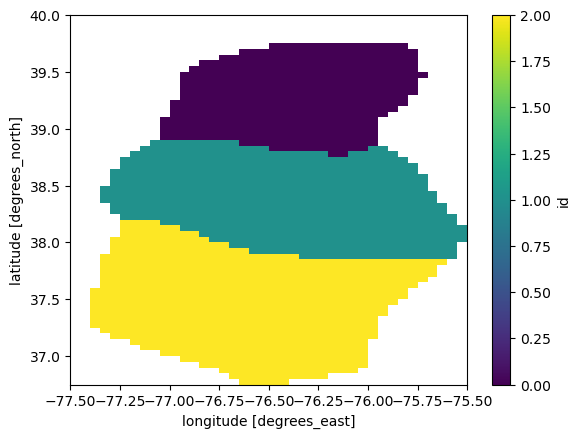

In [18]:
trad_zones_rast.plot()

Add metadata

In [20]:
trad_zones_rast.attrs = {
    'Description': 'A raster version of the chesapeake_traditional_zones on' \
    'a geopolar grid. Any pixels over land are marked with nan.',
    'Source': 'chesapeake_traditional_zones.geojson'
}

Save the file

In [21]:
trad_zones_rast.to_dataset(name='traditional_zones').to_netcdf(
    REPO_ROOT / 'data/interim' / 'chesapeake_traditional_zones.nc'
)